In [1]:
import re
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
from aging.plotting import figure, format_plots, legend
from aging.behavior.syllables import assign_onsets

In [2]:
format_plots()

In [3]:
rotations_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/wheel/running_wheel.parquet')

In [4]:
rotations_df['start'] = pd.to_datetime(rotations_df['start'])
rotations_df['end'] = pd.to_datetime(rotations_df['end'])

rotations_df['recording_duration_days'] = (rotations_df["end"] - rotations_df["start"]).dt.total_seconds() / 60 / 60 / 24

/tmp/ipykernel_23302/2459832895.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  rotations_df['start'] = pd.to_datetime(rotations_df['start'])


In [5]:
rotations_df['rotations_per_day'] = rotations_df['rotations'] / rotations_df['recording_duration_days']

In [6]:
rotations_df.head(n=3)

,name,start,end,rotations,file,recording_duration_days,rotations_per_day
0,78w1,2023-07-08 17:19:49,2023-07-09 10:52:53,5891.0,/Volumes/ESD-USB/wheel_06122023/07082023_v1_18...,0.731296,8055.558369
1,78w2,2023-07-08 17:19:49,2023-07-09 10:53:10,1698.0,/Volumes/ESD-USB/wheel_06122023/07082023_v1_18...,0.731493,2321.279727
2,78w3,2023-07-08 17:19:49,2023-07-09 10:53:27,1272.0,/Volumes/ESD-USB/wheel_06122023/07082023_v1_18...,0.731690,1738.441583


In [7]:
c = re.compile(r"^(\d{2})([wc])")
min_date = pd.to_datetime("2023-06-01")


def get_experiment_and_age(row):
    grps = c.match(row["subject_name"]).groups()
    starting_age = int(grps[0])
    exp = grps[1]
    current_age = starting_age + (row["date"] - min_date).days / 7
    row["age"] = current_age
    row["experiment"] = exp
    return row


def load_wheel_df():
    wheel_df = pd.read_parquet(
        "/n/groups/datta/win/longtogeny/data/ontogeny/version_03/wheel_syllable_df_v02.parquet"
    ).astype(
        dict(
            recon_width="float32[pyarrow]",
            recon_length="float32[pyarrow]",
            recon_height="float32[pyarrow]",
            recon_area="float32[pyarrow]",
        )
    )

    mouse_id = wheel_df["subject_name"].str[:-3]
    wheel_df["mouse_id"] = mouse_id
    wheel_df = wheel_df[~wheel_df["subject_name"].str.startswith("M")].copy()
    wheel_df = assign_onsets(wheel_df)
    search_str = re.compile(r"[wc](\d)")
    wheel_df["cage"] = wheel_df["subject_name"].apply(
        lambda s: search_str.search(s).group(1)
    )
    # wheel_df = wheel_df.apply(get_experiment_and_age, axis=1)
    return wheel_df

In [8]:
wheel_df = load_wheel_df()

In [9]:
rotations_df.head()

,name,start,end,rotations,file,recording_duration_days,rotations_per_day
0,78w1,2023-07-08 17:19:49,2023-07-09 10:52:53,5891.0,/Volumes/ESD-USB/wheel_06122023/07082023_v1_18...,0.731296,8055.558369
1,78w2,2023-07-08 17:19:49,2023-07-09 10:53:10,1698.0,/Volumes/ESD-USB/wheel_06122023/07082023_v1_18...,0.731493,2321.279727
2,78w3,2023-07-08 17:19:49,2023-07-09 10:53:27,1272.0,/Volumes/ESD-USB/wheel_06122023/07082023_v1_18...,0.731690,1738.441583
3,78w4,2023-07-08 17:19:49,2023-07-09 10:53:38,5978.0,/Volumes/ESD-USB/wheel_06122023/07082023_v1_18...,0.731817,8168.707397
4,12w1,2023-07-08 17:19:49,2023-07-09 10:53:47,11392.0,/Volumes/ESD-USB/wheel_06122023/07082023_v1_18...,0.731921,15564.515007


[Text(0.5, 0, 'Days of wheel recording')]

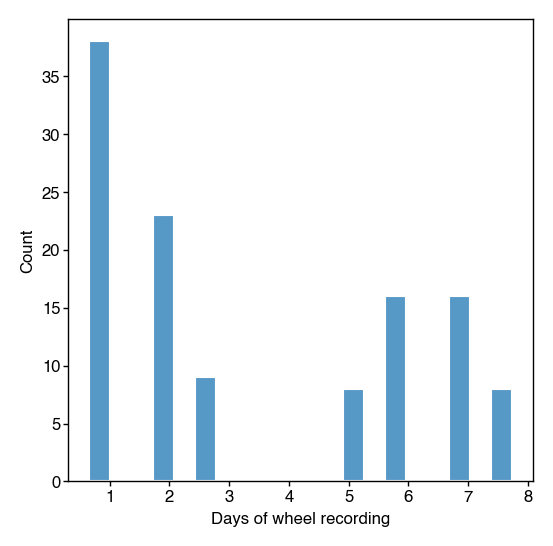

In [10]:
ax = sns.histplot(
    (rotations_df["end"] - rotations_df["start"]).dt.total_seconds() / 60 / 60 / 24,
    bins=20,
)
ax.set(xlabel="Days of wheel recording") 

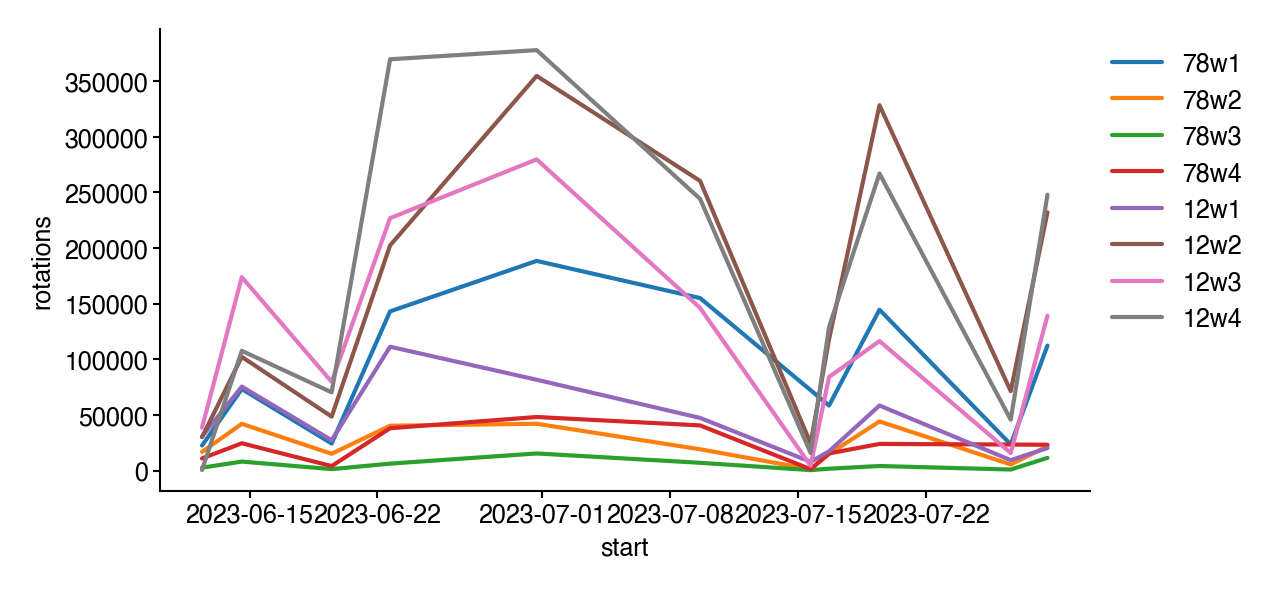

In [11]:
figure(4, 2)
ax = sns.lineplot(data=rotations_df.query('recording_duration_days > 1'), x='start', y='rotations', hue='name')
legend(ax)
sns.despine()

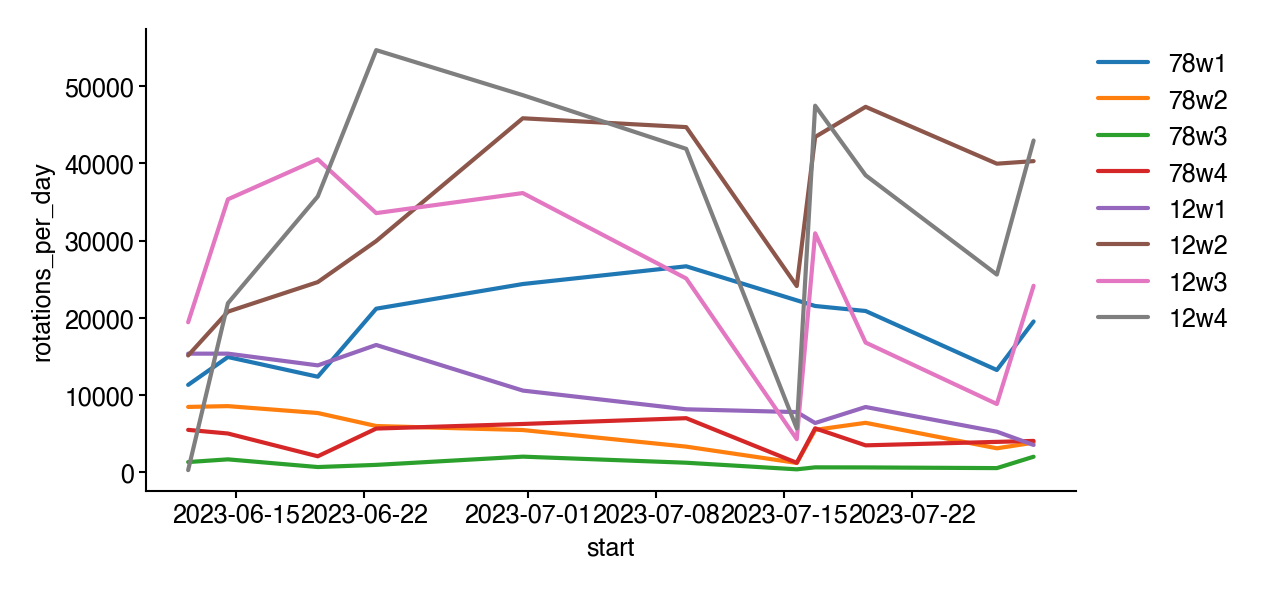

In [12]:
figure(4, 2)
ax = sns.lineplot(
    data=rotations_df.query("recording_duration_days > 1"),
    x="start",
    y="rotations_per_day",
    hue="name",
)
legend(ax)
sns.despine()

In [13]:
cat_df = []
for keys, _df in tqdm(
    rotations_df.query("recording_duration_days > 1").groupby(["name", "start"])
):
    try:
        mask = wheel_df["subject_name"].str.startswith(_df["name"].iloc[0])
        days = wheel_df.loc[mask, "date"].drop_duplicates()
        session_index = (
            (days - _df["end"].iloc[0]).where(lambda v: v > pd.Timedelta(0)).idxmin()
        )
        min_diff = (
            (days - _df["end"].iloc[0]).where(lambda v: v > pd.Timedelta(0)).min()
        )

        mask = wheel_df["date"] == days.loc[session_index]

        index = wheel_df.index[mask]

        new_df = pd.DataFrame(
            dict(rotations=_df["rotations_per_day"].iloc[0], recording_delta=min_diff),
            index=index,
        )
        cat_df.append(new_df)
    except Exception:
        continue
cat_df = pd.concat(cat_df)

  0%|          | 0/86 [00:00<?, ?it/s]

In [14]:
cat_df.head()

,rotations,recording_delta
11471601,15333.870855,6 days 23:40:24
11471602,15333.870855,6 days 23:40:24
11471603,15333.870855,6 days 23:40:24
11471604,15333.870855,6 days 23:40:24
11471605,15333.870855,6 days 23:40:24


In [15]:
# NOTE: there are some bugs here to iron out, like data duplication
cat_df['recording_delta'].drop_duplicates()

11471601    6 days 23:40:24
11471601    1 days 21:09:59
11975114    0 days 00:58:24
9242028     0 days 00:45:36
9277991     0 days 01:03:37
                 ...       
12406633    1 days 00:15:52
15211488    1 days 00:56:11
9529719    11 days 17:38:15
9529719     9 days 00:28:58
9529719     2 days 01:01:16
Name: recording_delta, Length: 74, dtype: timedelta64[ns]

In [16]:
wheel_df = wheel_df.join(cat_df)

In [17]:
sample = wheel_df.groupby(["date", "experiment", "subject_name"]).mean(numeric_only=True).reset_index().apply(get_experiment_and_age, axis=1)

<Axes: xlabel='age', ylabel='rotations'>

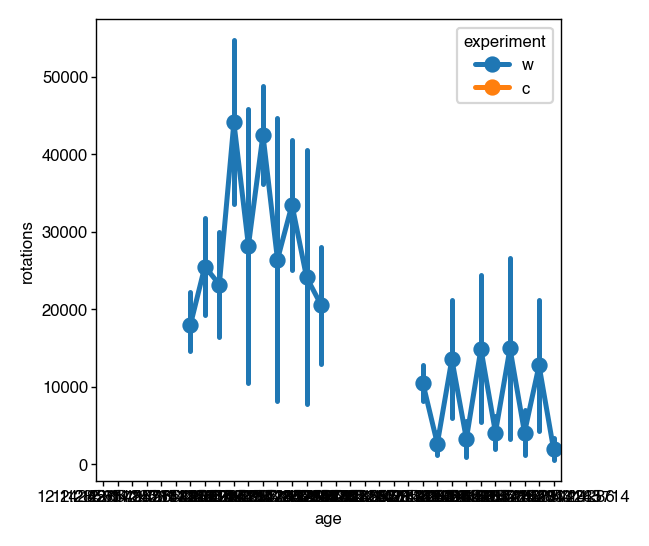

In [18]:
sns.pointplot(
    data=sample,
    x="age",
    y="rotations",
    hue="experiment",
)